## Lenskit recommendation generation


In [ ]:
%%capture
!pip install wget

In [ ]:
import pandas as pd
import os
import wget

### Reading the dataset:

In [ ]:
%%capture
wget.download('https://files.grouplens.org/datasets/movielens/ml-latest-small.zip')
# !unzip ml-latest.zip
!unzip ml-latest-small.zip

### RecBole Library:
Original page: https://recbole.io/

Github: https://github.com/RUCAIBox/RecBole

Documentation: https://recbole.io/docs/index.html

In [ ]:
%%capture
!pip install recbole
!pip install ray

In [ ]:
# from recbole.quick_start import run_recbole
# run_recbole(model='BPR', dataset='ml-20m')

### Lenskit Library:
Original page: https://lenskit.org/

Documentation: https://lkpy.readthedocs.io/en/stable/install.html

In [ ]:
%%capture
!pip install lenskit
!pip install tbb

In [ ]:
%env MKL_THREADING_LAYER = tbb ## Performance optimization

os.environ['MKL_THREADING_LAYER'] = 'tbb'

env: MKL_THREADING_LAYER=tbb ## Performance optimization


In [ ]:
from lenskit.datasets import MovieLens
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, funksvd,  item_knn as iknn, user_knn as uknn
from lenskit.algorithms.basic import PopScore, UnratedItemCandidateSelector
from lenskit import topn
from lenskit.datasets import ML100K

In [ ]:
mllatest = MovieLens('ml-latest')
ml100k = MovieLens('ml-latest-small')

## to load and view various properties:
ratings = ml100k.ratings ##or .movies,links,tags,tag_genome

In [ ]:
ratings = mllatest.ratings
candidate_list = [x for x in range(1,2000)]
ratings = ratings[ratings.user.isin(candidate_list)]
len(ratings)

151415

#### Algorithms

In [ ]:
## Basic:
algo_b1_pop = PopScore(score_method='quantile') # The PopScore algorithm scores items by their populariy for enabling most-popular-item recommendation.
algo_b2_un = UnratedItemCandidateSelector # A candidate selector that remembers items users have rated, and returns a candidate set consisting of all unrated items.

## KNN:
algo_k1_i = iknn.ItemItem(20) #item-item CF, 20 as number of neighbors to consider
algo_k2_u = uknn.UserUser(20) #user-user CF, 20 as number of neighbors to consider

## MF:
algo_BMF = als.BiasedMF(50) # Arg is the number of features to train
algo_FSVD = funksvd.FunkSVD(50)

In [ ]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()

    recs = batch.recommend(fittable, users, 100) # n is the number of recommendations to generate (None for unlimited)
  
    recs['Algorithm'] = aname
    return recs


all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)

    all_recs.append(eval('Popularity', algo_b1_pop, train, test))

    all_recs.append(eval('ItemItem', algo_k1_i, train, test))
    all_recs.append(eval('UserUser', algo_k2_u, train, test))

    all_recs.append(eval('ALSBMF', algo_BMF, train, test))
    all_recs.append(eval('ALSFunk', algo_FSVD, train, test))


all_recs = pd.concat(all_recs, ignore_index=True)
test_data = pd.concat(test_data, ignore_index=True)

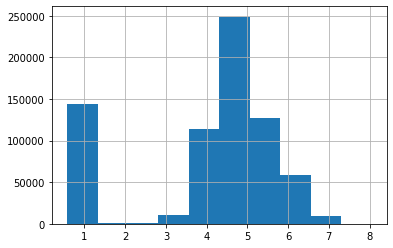

In [ ]:
all_recs.score.hist()

In [ ]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALSBMF        0.046547
ALSFunk       0.018533
ItemItem      0.002042
Popularity    0.163502
UserUser      0.000059
Name: ndcg, dtype: float64

Lenskit is obviously out! The performance is way off.